<a href="https://colab.research.google.com/github/Atharva-Peshkar/DeepFake-Detector/blob/main/Deepfake_1_(Frame_Extraction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Installing Dependecies, configuring notebook and downloading dataset

In [ ]:
'''!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v
!pip install kaggle --upgrade'''

'!pip uninstall -y kaggle\n!pip install --upgrade pip\n!pip install kaggle==1.5.6\n!kaggle -v\n!pip install kaggle --upgrade'

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/DeepFake/

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/DeepFake


In [ ]:
'''import os
os.environ['KAGGLE_USERNAME'] = "peshkaratharva" 
os.environ['KAGGLE_KEY'] = "993b3b76891f8707cec9d09b2463d78d"
!ls
!kaggle competitions download -c deepfake-detection-challenge'''

'import os\nos.environ[\'KAGGLE_USERNAME\'] = "peshkaratharva" \nos.environ[\'KAGGLE_KEY\'] = "993b3b76891f8707cec9d09b2463d78d"\n!ls\n!kaggle competitions download -c deepfake-detection-challenge'

In [ ]:
#!ls

In [ ]:
#!unzip '/gdrive/My Drive/Colab Notebooks/DeepFake/deepfake-detection-challenge.zip'

In [ ]:
#!pip install face_recognition

###Data Analysis

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd

In [ ]:
#this is the base working directory

main_dir = '/gdrive/My Drive/Colab Notebooks/DeepFake/'

In [ ]:
metadata = pd.read_json(os.path.join(main_dir,'train_sample_videos/metadata.json')).T
print(pd.Series(metadata['original']).value_counts())

In [ ]:
print(metadata.label.head())

aagfhgtpmv.mp4    FAKE
aapnvogymq.mp4    FAKE
abarnvbtwb.mp4    REAL
abofeumbvv.mp4    FAKE
abqwwspghj.mp4    FAKE
Name: label, dtype: object


In [ ]:
train_list = os.listdir(os.path.join(main_dir,'train_sample_videos/'))
meta = np.array(list(metadata.index))
storage = np.array([file for file in train_list if  file.endswith('mp4')])
print(f"Metadata: {meta.shape[0]}, Folder: {storage.shape[0]}")
print(f"Files in metadata and not in folder: {np.setdiff1d(meta,storage,assume_unique=False).shape[0]}")
print(f"Files in folder and not in metadata: {np.setdiff1d(storage,meta,assume_unique=False).shape[0]}")

['FAKE' 'REAL']
Real: 77
Fake: 323


Text(0, 0.5, 'Number of videos')

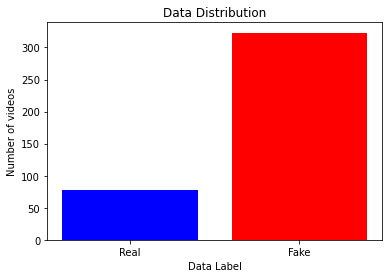

In [ ]:
#Data Distribution Analysis
import matplotlib.pyplot as plt
print(metadata.label.unique())
print(f"Real: {(metadata.label=='REAL').sum()}")
print(f"Fake: {(metadata.label=='FAKE').sum()}")
plt.bar(['Real','Fake'],[(metadata.label=='REAL').sum(),(metadata.label=='FAKE').sum()],color=['blue','red'])
plt.title('Data Distribution')
plt.xlabel('Data Label')
plt.ylabel("Number of videos")

###Moving files from training folder to real and fake folder respectively, after creating them

In [ ]:
#Function to create new directories if they do not exist. Syntax: dir_creator(parent_dir_path , new_dir_name)

def dir_creator(path_val,dir_name):
  if(os.path.isdir(os.path.join(path_val,dir_name))):
    print(f"Folder named: {dir_name}, already exists, good to go!\n")
  else:
    print(f"Folder named: {dir_name}, created for you, go ahead!\n")
    os.mkdir(os.path.join(path_val,dir_name))

In [ ]:
'''creating the directories and sub-directories for segregating videos
Directory structure:

+ DeepFake                      |       +DeepFake
  + Real                        |         +Fake
    +videos                     |           +videos
      =>data-points             |             => data-points '''


source = os.path.join(main_dir,'train_sample_videos/')
dir_creator(main_dir,'Real')
dir_creator(os.path.join(main_dir,'Real'),'videos')
dir_creator(main_dir,'Fake')
dir_creator(os.path.join(main_dir,'Fake'),'videos')

Folder named: Real, already exists, good to go!

Folder named: videos, already exists, good to go!

Folder named: Fake, already exists, good to go!

Folder named: videos, already exists, good to go!



In [ ]:
#Segregating all the REAL and FAKE label videos into different folders, from the main train_sample_videos directory
for fn in metadata.index:
  if(metadata.loc[fn]['label']=='REAL'):
    shutil.move(os.path.join(source,fn),os.path.join(real_dest,fn),copy_function = shutil.copytree)
  elif(metadata.loc[fn]['label']=='FAKE'):
    shutil.move(os.path.join(source,fn),os.path.join(fake_dest,fn),copy_function = shutil.copytree)
  else:
    print("File not found!")
    continue

In [ ]:
#diagnostic step, checking if all the files are there.
print(f'Files in train directory : {len(os.listdir(source))}')
print(f'Files in REAL directory : {len(os.listdir(real_dest))}')
print(f'Files in FAKE directory : {len(os.listdir(fake_dest))}')

Files in train directory : 4
Files in REAL directory : 1
Files in FAKE directory : 1


###Splitting the videos into frames

In [ ]:
##Function for extracting frames from a given video. Syntax: frame_extractor(base_dir,dest_dir)

def frame_extractor(base_dir,dest_dir):
  import cv2 
  import os 
  
  frame_list = [f for f in os.listdir(base_dir) if f.endswith('.mp4')]

  for fn in frame_list:
    cam = cv2.VideoCapture(os.path.join(base_dir,fn)) 
    cam.set(cv2.CAP_PROP_FPS, 24)
    while(True): 
      
      # reading from frame 
      ret,frame = cam.read() 

      if ret: 
        # if video is still left continue creating images 
        name = dest_dir+'frame' + str(cam.get(cv2.CAP_PROP_POS_FRAMES)) + '.jpg'
        print ('Creating...' + name) 

        # writing the extracted images 
        cv2.imwrite(name, frame) 

        # increasing counter so that it will 
        # show how many frames are created 
        #currentframe += 1
      else: 
        break

    # Release all space and windows once done 
    cam.release() 
    cv2.destroyAllWindows() 


In [ ]:
#create these folders to store all the extracted frames from videos, in the next cell.
dir_creator(os.path.join(main_dir,'Fake/'),'FakeFrames')  
dir_creator(os.path.join(main_dir,'Real/'),'RealFrames')

Folder named: FakeFrames, already exists, good to go!

Folder named: RealFrames, already exists, good to go!



In [ ]:
FakeBase = os.path.join(main_dir,'Fake/videos/')                   #the base directory where the FAKE videos are stored
FakeDest = os.path.join(main_dir,'Fake/FakeFrames/')               #the directory where you want to store the FAKE extracted frames
RealBase = os.path.join(main_dir,'Real/videos/')                   #the base directory where the REAL videos are stored
RealDest = os.path.join(main_dir,'Real/RealFrames/')               #the directory where you want to store the REAL extracted frames

###These processes below can take a lot of time. Upto 4 Hours

In [ ]:
frame_extractor(RealBase,RealDest)    #Extracting REAL FRAMES
print("\n *** Frames extracted successfully! *** \n")

Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Real/RealFrames/frame1.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Real/RealFrames/frame2.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Real/RealFrames/frame3.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Real/RealFrames/frame4.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Real/RealFrames/frame5.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Real/RealFrames/frame6.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Real/RealFrames/frame7.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Real/RealFrames/frame8.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Real/RealFrames/frame9.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Real/RealFrames/frame10.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Real/RealFrames/frame11.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Real/RealFrames/frame12.0.jpg
Creating.../g

In [ ]:
frame_extractor(FakeBase,FakeDest)    #Extracting FAKE FRAMES
print("\n *** Frames extracted successfully! *** \n")

Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Fake/FakeFrames/frame1.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Fake/FakeFrames/frame2.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Fake/FakeFrames/frame3.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Fake/FakeFrames/frame4.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Fake/FakeFrames/frame5.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Fake/FakeFrames/frame6.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Fake/FakeFrames/frame7.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Fake/FakeFrames/frame8.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Fake/FakeFrames/frame9.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Fake/FakeFrames/frame10.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Fake/FakeFrames/frame11.0.jpg
Creating.../gdrive/My Drive/Colab Notebooks/DeepFake/Fake/FakeFrames/frame12.0.jpg
Creating.../g